# Домашнее задание. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10.

In [1]:
import tensorflow as tf

import tqdm

import pydot
import graphviz

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [2]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

(40000, 32, 32, 3) (40000, 1)


Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

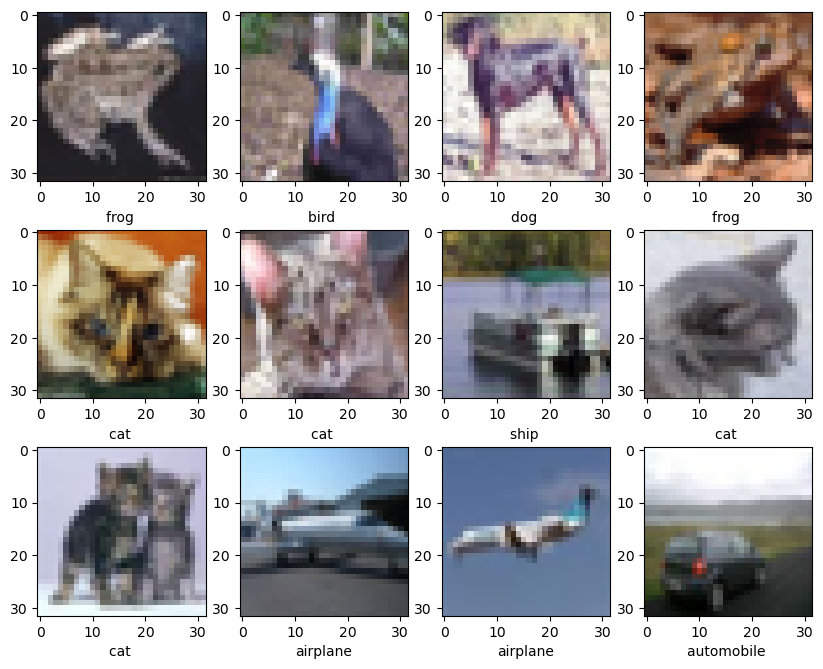

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[10,8])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

In [4]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

Исполните код ниже для проверки, что все выполнено корректно.

In [5]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

Создайте полносвязную сеть:

In [28]:
import keras
from keras import layers as L
from keras import backend as K
from keras import Model

In [7]:
X_train.shape[1:]

(32, 32, 3)

In [8]:
model1 = keras.models.load_model('models/model.keras')

In [9]:
# model = tf.keras.models.Sequential([
#         tf.keras.layers.Input(shape=X_train.shape[1:]),
#         tf.keras.layers.Dense(32, activation='relu'),
#         tf.keras.layers.Flatten(),
#         tf.keras.layers.Dense(32, activation='relu'),
#         tf.keras.layers.Dense(32, activation='relu'),
#         tf.keras.layers.Dense(10, activation='softmax')

# ])

In [10]:
model1.summary(expand_nested=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32, 32, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │       1,048,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,050,124 (4.01 MB)

 Trainable params: 1,050,122 (4.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

<div class='alert alert-block alert-danger'><h3> Вопрос</h3

Правильно ли понимаю, что в первом слое на выходе в последнем измерении получается размерность 32 (..., ..., ..., 32), потому что идёт операция матричного умножения вида:
- Input[1x3] @ Weights[3x32] = Argument_for_activation_function[1x32], 

где [1x3] - размеры input-вектора разметки RGB, а [3х32] - размерность элементов первого скрытого слоя, и, соответственно, весов, на которые надо домножить input

<div class='alert alert-block alert-danger'> 

In [9]:
dummy_pred = model1.predict(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
Успех!


## Обучение сети

**Задание 1.1 (обязательно)** Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard) или [wandb](https://docs.wandb.ai/integrations/jupyter). **Важно: логи tensorboard не получится без боли посмотреть через colab.** Workaround: скачать логи и запустить tensorboard локально или помучаться [с этим](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [486]:
y_train, y_val = (keras.utils.to_categorical(y) for y in (y_train, y_val))

In [489]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='logs/epochs/model.{epoch:02d}-{val_loss:.2f}.keras'),
             tf.keras.callbacks.TensorBoard(log_dir='./logs'),
             tf.keras.callbacks.EarlyStopping(patience=3)]

In [491]:
## TODO
model1.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
    metrics = ['categorical_accuracy']
)
model1.fit(X_train, y_train, batch_size=64, epochs=15, callbacks=callbacks, validation_split=0.2)

Epoch 1/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - categorical_accuracy: 0.5794 - loss: 1.1988 - val_categorical_accuracy: 0.5004 - val_loss: 1.4382
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - categorical_accuracy: 0.5829 - loss: 1.1945 - val_categorical_accuracy: 0.5035 - val_loss: 1.4186
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - categorical_accuracy: 0.5926 - loss: 1.1642 - val_categorical_accuracy: 0.5010 - val_loss: 1.4244
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - categorical_accuracy: 0.5940 - loss: 1.1543 - val_categorical_accuracy: 0.5105 - val_loss: 1.4205
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - categorical_accuracy: 0.6010 - loss: 1.1411 - val_categorical_accuracy: 0.5030 - val_loss: 1.4340


А теперь можно проверить качество вашей сети, выполнив код ниже:

In [492]:
from sklearn.metrics import accuracy_score

predict_x=model1.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

 Test_acc = 0.5075
 Not bad!


In [ ]:
keras.models.save_model(model, 'models/model.keras')

## Карманная сверточная сеть

**Задание 1.2 (обязательно)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [15]:
X_train.shape[1:]

(32, 32, 3)

In [493]:
new_model = keras.models.load_model('models/new_model.keras')

In [494]:
## TODO
new_model = keras.models.Sequential([
    L.Input(shape=X_train.shape[1:]), #1
    L.Conv2D(filters=10,
            kernel_size=(3, 3),
            padding='same',
            activation='leaky_relu'), #2-3
    L.MaxPool2D(pool_size=(2,2), padding='valid'), #4
    L.Flatten(), #5
    L.Dense(100, activation='relu'), # 6-7
    L.Dense(10, activation='softmax') # 8
])

In [495]:
new_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='/models/new_model.{epoch:02d}-{val_loss:.2f}.keras'),
             tf.keras.callbacks.TensorBoard(log_dir='./logs'),
             tf.keras.callbacks.EarlyStopping(patience=3)]

In [496]:
new_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_834 (Conv2D)             │ (None, 32, 32, 10)     │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_95 (MaxPooling2D) │ (None, 16, 16, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2560)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 100)            │       256,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 257,390 (1005.43 KB)

 Trainable params: 257,390 (1005.43 KB)

 Non-trainable params: 0 (0.00 B)

In [498]:
###### TODO
new_model.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
    metrics = ['categorical_accuracy']
)

new_model.fit(X_train, y_train, batch_size=64, epochs=15, callbacks=new_callbacks, validation_split=0.2)

Epoch 1/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - categorical_accuracy: 0.2136 - loss: 2.1488 - val_categorical_accuracy: 0.3250 - val_loss: 1.9066
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - categorical_accuracy: 0.3438 - loss: 1.8646 - val_categorical_accuracy: 0.3736 - val_loss: 1.7831
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - categorical_accuracy: 0.3881 - loss: 1.7425 - val_categorical_accuracy: 0.3905 - val_loss: 1.7143
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - categorical_accuracy: 0.4141 - loss: 1.6657 - val_categorical_accuracy: 0.4370 - val_loss: 1.6236
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - categorical_accuracy: 0.4420 - loss: 1.5833 - val_categorical_accuracy: 0.4470 - val_loss: 1.5555
Epoch 6/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - categorical_accuracy: 0.4617 - loss: 1.5137 - val_categorical_accuracy: 0.4675 - val_loss: 1.4979
Epoch 7/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - categorical_accuracy: 0.4880 - los

Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [499]:
from sklearn.metrics import accuracy_score

predict_x = new_model.predict(X_test)
classes_x = np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

 Test_acc = 0.5485
 Not bad!


In [18]:
keras.models.save_model(new_model, 'models/new_model.keras')

## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций.

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

**Задание 1.3 (опционально)** Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Для удобства напишем класс Evaluator, который принимает в себя дикты виды {имя_оптимайзера: инстанс}, {имя модели: инстанс} и обучает всевозможные комбинации моделей с оптимайзерами при помощи метода fit (попутно записывая логи отдельно для каждой модели). Также пригодится метод evaluate для отображения итоговых скоров.

Пользоваться классом не обязательно. По умолчанию класс использует tensorboard. Если вы выше использовали wandb -- советуем дописать callback.

In [500]:
class Evaluator:
    def __init__(self, models: dict, optimizers: list[str]='adam', loss=keras.losses.sparse_categorical_crossentropy,
                 metrics=[keras.metrics.sparse_categorical_accuracy]):
        '''
            models: dict {name: model}
            optimizers: list of optimizers or just one optimizer
        '''
        
        self.optimizers = optimizers
        self.models = models
        
        self.models_compiler = [
            (model_name, keras.models.clone_model(model), optimizer) 
            for optimizer in optimizers 
            for model_name, model in models.items()
        ]
    
        for name, model, optimizer in self.models_compiler:
            model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        
    def fit(self, X, y, validation_data=(), max_epochs=100, verbose=0, callbacks=None, batch_size=32):
            
        for model_name, model, optimizer_name in tqdm.tqdm_notebook(self.models_compiler):
            model.fit(X, y, validation_data=validation_data or None, epochs=max_epochs, verbose=verbose,
                      batch_size=batch_size, callbacks=[
                          keras.callbacks.ModelCheckpoint(filepath='/models/{epoch:02d}-{val_loss:.2f}.keras', save_best_only=True),
                          keras.callbacks.TensorBoard(log_dir='./logs/experimental/{}_{}'.format(model_name, optimizer_name)),
                          keras.callbacks.EarlyStopping(patience=3)])
            
            keras.models.save_model(model, f'models/{model_name}_{optimizer_name}.keras')
            print(f'Model: {model_name} with optimizer: {optimizer_name}\nhaving {model.count_params()} params and {len(model.layers)} layers\nSuccessefully trained')
            
    def load_models(self):
        self.models_compiler = [
            (model_name, keras.models.load_model(f'models/{model_name}_{optimizer}.keras') , optimizer)
            for optimizer in self.optimizers
            for model_name, model in self.models.items()
        ]
            
    def evaluate(self, X, y, metric, compiled_models=None):
        if compiled_models == None:
            compiled_models = self.models_compiler
        for model_name, model, optimizer_name in compiled_models:
            print('Final score of {}_{} is {}'.format(model_name, optimizer_name,
                  metric(y, model.predict(X).argmax(axis=1))))

### TODO

- Create new models

In [16]:
optimizers_list = ['Adam', 'Nadam', 'RMSProp']

models_dict = {
    'basic' : model1,
    'conv_basic' : new_model}

In [17]:
evaluator = Evaluator(models_dict, optimizers=optimizers_list)

In [18]:
evaluator.load_models()

In [48]:
evaluator.fit(X_train, y_train, validation_data=(X_val, y_val), 
              max_epochs=15, batch_size=64)

C:\Users\Igor\AppData\Local\Temp\ipykernel_17280\1868541128.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for model_name, model, optimizer_name in tqdm.tqdm_notebook(self.models_compiler):


  0%|          | 0/6 [00:00<?, ?it/s]

Model: basic with optimizer: Adam
having 1050122 params and 5 layers
Successefully trained
Model: conv_basic with optimizer: Adam
having 257390 params and 5 layers
Successefully trained
Model: basic with optimizer: Nadam
having 1050122 params and 5 layers
Successefully trained
Model: conv_basic with optimizer: Nadam
having 257390 params and 5 layers
Successefully trained
Model: basic with optimizer: RMSProp
having 1050122 params and 5 layers
Successefully trained
Model: conv_basic with optimizer: RMSProp
having 257390 params and 5 layers
Successefully trained


In [19]:
evaluator.evaluate(X_test, y_test, accuracy_score)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Final score of basic_Adam is 0.4781
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Final score of conv_basic_Adam is 0.6095
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Final score of basic_Nadam is 0.396
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Final score of conv_basic_Nadam is 0.6175
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Final score of basic_RMSProp is 0.485
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Final score of conv_basic_RMSProp is 0.598


In [501]:
%load_ext tensorboard

In [502]:
%reload_ext tensorboard

In [503]:
%tensorboard --logdir logs/

Reusing TensorBoard on port 6006 (pid 20152), started 11:29:27 ago. (Use '!kill 20152' to kill it.)

Прокомментируйте полученные результаты.

<div class='alert alert-block alert-info'><h3><center> Выводы по 1.3</center></h3

1) Модели с Convolution в общем показывают лучшие результаты по всем отслеживаемым показателям как на обучении, так и на валидации.
2) Ни одна из моделей не прошла все 15 эпох. Быстрее всех учился Nadam, медленнее - Adam
3) Модели со свёрткой учатся быстрее полностью полносвязных с одинаковым количеством слоёв в силу меньшего числа тренировочных параметров

- По оптимизаторам (для свёрточных моделей):
1) RMSprop лучше показывает среднюю accuracy, но у него самый высокий loss. Может, ему нужно больше эпох.
2) Adam показывает средние результаты на loss и худшие на accuracy. 
3) Nadam (Нестеров) показывает самый крутой loss и самую крутую accuracy.Может быть, в силу того, что задано очень небольшое кол-во эпох. Думаю, что если его "докрутить", это будет лучший оптимизатор

<div class='alert alert-block alert-info'>

**Задание 1.4 (опционально)** Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

Для удобства реализуем класс Models, который по сути будет являться списком моделей с двумя методами: add (добавить слой ко всем моделям) и add_create (создать новую модель на основе базовой с дополнительным слоем). Пользоваться им необязательно, но вдруг :)

In [75]:
from collections import OrderedDict

class Models(OrderedDict):
    def __init__(self, models):
        if not isinstance(models, dict):
            models = OrderedDict({'base_model': models})
        super().__init__(models)

    def add(self, layer):
        for name, model in self.items():
            model.add(layer)

    def add_create(self, name, layer):
        base_model = next(iter(self.items()))[1]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

    def add_update(self, name, layer):
        base_model = self[next(reversed(self))]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

# Example of usage
# models = Models(keras.Sequential())
# models.add(L.InputLayer(input_shape=(32, 32, 3)))
# models.add(L.Convolution2D(filters=10, kernel_size=(3, 3)))
# models.add(L.MaxPooling2D())
# models.add_create('conv_batchnorm', L.BatchNormalization())
# models.add(L.Activation('relu'))
# ...

In [167]:
models = Models(keras.Sequential())
models.add(L.InputLayer(input_shape=X_train.shape[1:]))
models.add_create('conv_batchnorm', L.BatchNormalization())
models.add(L.Convolution2D(filters=10, kernel_size=(3, 3)))
models.add(L.MaxPooling2D())
models.add(L.Activation('leaky_relu'))
models.add(L.Flatten())
models.add(L.Dense(100, activation='relu'))
models.add_update('conv_batchnorm', L.BatchNormalization())
models.add(L.Dense(10, activation='softmax'))

In [168]:
models

Models([('base_model', <Sequential name=sequential_54, built=True>),
        ('conv_batchnorm', <Sequential name=sequential_54, built=True>)])

In [169]:
dict(models)['conv_batchnorm'].summary()

Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_69               │ (None, 32, 32, 3)           │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_87 (Conv2D)                   │ (None, 30, 30, 10)          │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_68 (MaxPooling2D)      │ (None, 15, 15, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_25 (Activation)           │ (None, 15, 15, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_44 (Flatten)                 │ (None, 2250)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_91 (Dense)                     │ (None, 100)                 │         225,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_70               │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_92 (Dense)                     │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 226,802 (885.95 KB)

 Trainable params: 226,596 (885.14 KB)

 Non-trainable params: 206 (824.00 B)

In [170]:
norm_evaluator = Evaluator(dict(models), optimizers=['Nadam'])

In [171]:
norm_evaluator.fit(X_train, y_train, validation_data=(X_val, y_val), 
                   max_epochs=20, batch_size=64)

C:\Users\Igor\AppData\Local\Temp\ipykernel_5636\139999458.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for model_name, model, optimizer_name in tqdm.tqdm_notebook(self.models_compiler):


  0%|          | 0/2 [00:00<?, ?it/s]

Model: base_model with optimizer: Nadam
having 226390 params and 6 layers
Successefully trained
Model: conv_batchnorm with optimizer: Nadam
having 226802 params and 8 layers
Successefully trained


In [173]:
norm_evaluator.evaluate(X_test, y_test, accuracy_score)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Final score of base_model_Nadam is 0.6137
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Final score of conv_batchnorm_Nadam is 0.6338


Прокомментируйте полученные результаты.

In [175]:
%tensorboard --logdir logs/

Reusing TensorBoard on port 6006 (pid 20152), started 0:29:33 ago. (Use '!kill 20152' to kill it.)

**Задание 1.5 (опционально)** Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%. **Hint**: используйте early stopping callback.

**Задание 1.6 (опционально)** Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

<div class='alert alert-block alert-info'><h3><center> Выводы по 1.4-1.6</center></h3

1) Нормализация помогла повысить финальную метрику модели
2) Оптимальный найденный батч - 64 
3) Многократные попытки показали, что лучше всего себя ведёт модель, в которой делаем нормализацию до свёртки, а затем ещё между полносвязными слоями, хотя кривые обучения получились не самого лучшего вида.

- Лучшей кривой обучения считаю ту, которая:
- a) меньше всего "виляет", и в итоге
- б) имеет наименьшие "отскоки" в процессе обучения

## Свёрточная нейросеть здорового человека

**Задание 1.7 (обязательно попытаться)** Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

# Preprocessing

In [504]:
from sklearn.metrics import accuracy_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pydot, graphviz

In [576]:
train_datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
# datagen.fit(X_train)

In [580]:
val_datagen = ImageDataGenerator()

In [581]:
# split = 32000
dg_x_train, dg_x_val, dg_y_train, dg_y_val = train_test_split(X_train, y_train, test_size=.2, random_state=5)

In [582]:
train_generator = train_datagen.flow(dg_x_train, dg_y_train, batch_size=64)

val_generator = val_datagen.flow(dg_x_val, dg_y_val)

### Эксперимент 1 (Just random layers)

- Построил сеть рандомного вида:
1) Свёртка - пулинг
2) Свёртка - пулинг
3) Свёртка - пулинг
4) 1d-выравнивание (flatten)
5) Нормализация
6) Dense - 128, leaky_relu
7) Dropout 20%
8) Dense - 128, relu
9) Output dense - 10, softmax

- Результаты:
на валидации около 52% точности

In [583]:
## TODO
just_random_layers = tf.keras.models.Sequential([
    L.Input(shape=X_train.shape[1:]),
    L.Conv2D(16, 2, activation='relu'),
    L.MaxPool2D(),
    L.Conv2D(32, 2, activation='relu'),
    L.AveragePooling2D((2, 2)),
    L.Conv2D(64, 2, activation='relu'),
    L.AveragePooling2D((2,2)),
    L.Flatten(),
    L.BatchNormalization(),
    L.Dense(128, activation='leaky_relu'),
    L.Dropout(.2),
    L.Dense(128, activation='relu'),
    L.Dense(10, activation='softmax')
])

In [548]:
new_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='/models/new_model.{epoch:02d}-{val_loss:.2f}.keras'),
             tf.keras.callbacks.TensorBoard(log_dir='./logs'),
             tf.keras.callbacks.EarlyStopping(patience=10)]

In [22]:
just_random_layers.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 29, 29, 16)          │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 32)          │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 2, 2, 64)            │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,218 (266.48 KB)

 Trainable params: 68,090 (265.98 KB)

 Non-trainable params: 128 (512.00 B)

In [584]:
## TODO
just_random_layers.compile(
    optimizer='Nadam',
    loss='categorical_crossentropy',
    metrics = ['categorical_accuracy']
)

just_random_layers.fit(train_generator, epochs=32, 
                callbacks=new_callbacks, validation_data=val_generator)

Epoch 1/32


C:\Users\Igor\AppData\Local\Programs\Python\conda\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - categorical_accuracy: 0.3348 - loss: 1.8235 - val_categorical_accuracy: 0.4874 - val_loss: 1.5904
Epoch 2/32
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - categorical_accuracy: 0.4746 - loss: 1.4683 - val_categorical_accuracy: 0.5350 - val_loss: 1.3094
Epoch 3/32
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - categorical_accuracy: 0.5076 - loss: 1.3716 - val_categorical_accuracy: 0.4964 - val_loss: 1.4976
Epoch 4/32
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - categorical_accuracy: 0.5325 - loss: 1.3081 - val_categorical_accuracy: 0.5922 - val_loss: 1.1894
Epoch 5/32
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - categorical_accuracy: 0.5461 - loss: 1.2606 - val_categorical_accuracy: 0.5769 - val_loss: 1.2416
Epoch 6/32
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - categorical_accuracy: 0.5684 - loss: 1.2147 - val_categorical_accuracy: 0.4897 - val_loss: 1.6049
Epoch 7/32
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - categorical_accuracy: 0.5731 - 

Момент истины: проверьте, какого качества достигла ваша сеть.

In [585]:
def scorer(model):
    predict_x=model.predict(X_test)
    classes_x=np.argmax(predict_x,axis=1)

    test_acc = accuracy_score(y_test, classes_x)
    print("\n Test_acc =", test_acc)
    if test_acc > 0.8:
        print("Это победа!")

In [586]:
scorer(just_random_layers)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

 Test_acc = 0.6426


### Выводы по рандомной наслоенной модели

1) Вышла какая-то ерунда
2) Мало Батчнорма
3) Неглубокая структура не справилась с обучением изображений с аугментацией
4) Будем пробовать что-то более sophisticated

### Эксперимент 2 (DenseNet stolen from Kaggle )


In [558]:
class DenseNet:
    def __init__(self, input_shape=None, dense_blocks=3, dense_layers=-1, growth_rate=12, nb_classes=None,
                 dropout_rate=None, bottleneck=False, compression=1.0, weight_decay=1e-4, depth=40):

        # Checks
        if nb_classes == None:
            raise Exception(
                'Please define number of classes (e.g. num_classes=10). This is required for final softmax.')

        if compression <= 0.0 or compression > 1.0:
            raise Exception('Compression have to be a value between 0.0 and 1.0.')

        if type(dense_layers) is list:
            if len(dense_layers) != dense_blocks:
                raise AssertionError('Number of dense blocks have to be same length to specified layers')
        elif dense_layers == -1:
            dense_layers = int((depth - 4) / 3)
            if bottleneck:
                dense_layers = int(dense_layers / 2)
            dense_layers = [dense_layers for _ in range(dense_blocks)]
        else:
            dense_layers = [dense_layers for _ in range(dense_blocks)]

        self.dense_blocks = dense_blocks
        self.dense_layers = dense_layers
        self.input_shape = input_shape
        self.growth_rate = growth_rate
        self.weight_decay = weight_decay
        self.dropout_rate = dropout_rate
        self.bottleneck = bottleneck
        self.compression = compression
        self.nb_classes = nb_classes
        
    def build_model(self):
        img_input = L.Input(shape=self.input_shape, name='img_input')
        nb_channels = self.growth_rate
        
        x = L.Conv2D(2*self.growth_rate, (3,3), 
                   padding='same', strides = (1,1), 
                   kernel_regularizer=keras.regularizers.l2(self.weight_decay))(img_input)
        
        for block in range(self.dense_blocks-1):
            x, nb_channels = self.dense_block(x, self.dense_layers[block], nb_channels, self.growth_rate,
                                              self.dropout_rate, self.bottleneck, self.weight_decay)
            
            x = self.transition_layer(x, nb_channels, self.dropout_rate, self.compression, self.weight_decay)
            nb_channels = int(nb_channels*self.compression)
            
        x, nb_channels = self.dense_block(x, self.dense_layers[-1], nb_channels, self.growth_rate, 
                                          self.dropout_rate, self.weight_decay)
        
        x = L.BatchNormalization()(x)
        x = L.Activation('relu')(x)
        x = L.GlobalAveragePooling2D()(x)
        prediction = L.Dense(self.nb_classes, activation='softmax')(x)
        
        return Model(inputs=img_input, outputs=prediction, name='densenet')
        
    def dense_block(self, x, nb_layers, nb_channels, growth_rate, dropout_rate=None, bottleneck=False, weight_decay=1e-4):
        for i in range(nb_layers):
            cb = self.convolution_block(x, growth_rate, dropout_rate, bottleneck)
            nb_channels += growth_rate
            x = L.concatenate([cb,x])
            
        return x, nb_channels
    
    def convolution_block(self, x, nb_channels, dropout_rate=None, bottleneck=False, weight_decay=1e-4):       
        # Standard (BN-ReLU-Conv)
        x = L.BatchNormalization()(x)
        x = L.Activation('relu')(x)
        x = L.Conv2D(nb_channels, (3, 3), padding='same')(x)

        
        # Dropout
        if dropout_rate:
            x = L.Dropout(dropout_rate)(x)

        return x

    def transition_layer(self, x, nb_channels, dropout_rate=None, compression=1.0, weight_decay=1e-4):
        x = L.BatchNormalization()(x)
        x = L.Activation('relu')(x)
        x = L.Conv2D(int(nb_channels * compression), (1, 1), padding='same',
                                 kernel_regularizer=keras.regularizers.l2(weight_decay))(x)

        # Adding dropout
        if dropout_rate:
            x = Dropout(dropout_rate)(x)

        x = L.AveragePooling2D((2, 2), strides=(2, 2))(x)
        return x

In [563]:
dense_net = DenseNet(input_shape=X_train.shape[1:], nb_classes=len(class_names), depth=12)

In [564]:
dense_net_model = dense_net.build_model()

In [565]:
dense_net_model.summary(expand_nested=True)

Model: "densenet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_input           │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_862 (Conv2D) │ (None, 32, 32,    │        672 │ img_input[0][0]   │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         96 │ conv2d_862[0][0]  │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_429      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_863 (Conv2D) │ (None, 32, 32,    │      2,604 │ activation_429[0… │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_367     │ (None, 32, 32,    │          0 │ conv2d_863[0][0], │
│ (Concatenate)       │ 36)               │            │ conv2d_862[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        144 │ concatenate_367[… │
│ (BatchNormalizatio… │ 36)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_430      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 36)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_864 (Conv2D) │ (None, 32, 32,    │      3,900 │ activation_430[0… │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_368     │ (None, 32, 32,    │          0 │ conv2d_864[0][0], │
│ (Concatenate)       │ 48)               │            │ concatenate_367[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        192 │ concatenate_368[… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_431      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_865 (Conv2D) │ (None, 32, 32,    │      1,764 │ activation_431[0… │
│                     │ 36)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 16, 16,    │          0 │ conv2d_865[0][0]  │
│ (AveragePooling2D)  │ 36)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        144 │ average_pooling2… │
│ (BatchNormalizatio… │ 36)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_432      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 36)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_866 (Conv2D) │ (None, 16, 16,    │      3,900 │ activation_432[0

 Total params: 38,698 (151.16 KB)

 Trainable params: 37,762 (147.51 KB)

 Non-trainable params: 936 (3.66 KB)

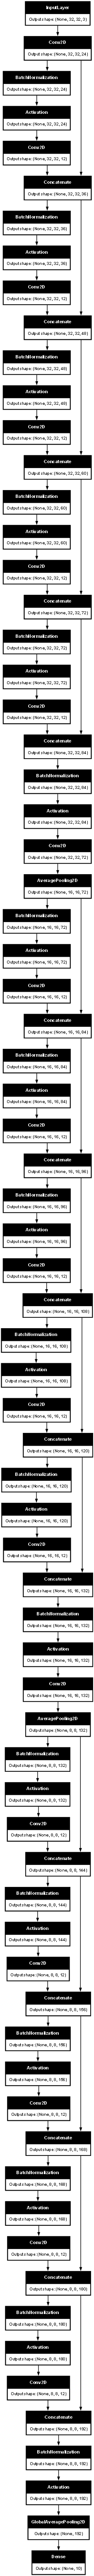

In [177]:
keras.utils.plot_model(dense_net_model, show_shapes=True, dpi=50)

In [566]:
dense_net_model.compile(
    optimizer='Nadam',
    loss='categorical_crossentropy',
    metrics = ['categorical_accuracy']
)

dense_net_model.fit(train_generator, epochs=32, 
              callbacks=new_callbacks, validation_data=val_generator)

Epoch 1/32
500/500 ━━━━━━━━━━━━━━━━━━━━ 95s 177ms/step - categorical_accuracy: 0.3063 - loss: 1.8977 - val_categorical_accuracy: 0.2570 - val_loss: 2.3174
Epoch 2/32
500/500 ━━━━━━━━━━━━━━━━━━━━ 88s 176ms/step - categorical_accuracy: 0.4608 - loss: 1.5038 - val_categorical_accuracy: 0.1941 - val_loss: 5.6460
Epoch 3/32
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 178ms/step - categorical_accuracy: 0.5200 - loss: 1.3431 - val_categorical_accuracy: 0.1443 - val_loss: 7.2239
Epoch 4/32
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 177ms/step - categorical_accuracy: 0.5571 - loss: 1.2611 - val_categorical_accuracy: 0.1478 - val_loss: 8.7676
Epoch 5/32
500/500 ━━━━━━━━━━━━━━━━━━━━ 90s 179ms/step - categorical_accuracy: 0.5734 - loss: 1.2022 - val_categorical_accuracy: 0.1724 - val_loss: 6.3655
Epoch 6/32
500/500 ━━━━━━━━━━━━━━━━━━━━ 90s 179ms/step - categorical_accuracy: 0.5961 - loss: 1.1578 - val_categorical_accuracy: 0.1992 - val_loss: 6.3424
Epoch 7/32
500/500 ━━━━━━━━━━━━━━━━━━━━ 90s 180ms/step - categorical_a

In [587]:
scorer(dense_net_model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step

 Test_acc = 0.2084


### Выводы по ДенсНет

1) Интересный экспириенс... Оооочень долгая сходимость
2) Вероятно, напортачил с потоком ввода трейновых/валидационных данных
3) Прирост показателей на трейне значительно превосходит оный на валидации
4) Пробовал тренировать с глубиной в 21 слой (21 свёртку). Показатели росли быстрее, и оказались намного лучше - рекорд с этой сеткой - 74%

- Украл структуру с кэггла и немного поменял. Очень громоздкая для домашнего задания. Буду дальше пробовать улучшать в своих обучающих проектах

### Hand-made ResNet

In [588]:
class ResNet:
    def __init__(self, input_shape=None, growth_rate=2, n_classes=None, depth=9):
        
        self.input_shape = input_shape
        self.growth_rate = growth_rate
        self.n_classes=n_classes
        self.depth = depth
        
    def build_model(self):
        nb_channels = int(self.input_shape[1]/2)
        
        img_inp = L.Input(shape=self.input_shape)
        x = L.Conv2D(nb_channels, (7,7), 
           padding='same', strides = (2, 2))(img_inp)
        
        X = L.MaxPool2D(strides=(2,2))(x)

        
        for i in range(int(self.depth/2)):
            cb, x = self.conv_layer(x, nb_channels)
            x = L.concatenate([cb,x])
            x = L.AveragePooling2D(pool_size=(2, 2), strides=(2,2))(x)
            x = L.BatchNormalization()(x)
            x = L.Activation('leaky_relu')(x)
            
            nb_channels += nb_channels
            
        x = L.GlobalAveragePooling2D()(x)
        x = L.Dense(nb_channels, activation='relu')(x)
        prediction = L.Dense(self.n_classes, activation='softmax')(x)
        
        return Model(inputs=img_inp, outputs=prediction, name='densenet')
    
    
            
    def conv_layer(self, x, nb_channels):
        cb = x
        for i in range(4):
            cb = L.Conv2D(nb_channels, (3, 3), padding='same')(cb)
            cb = L.BatchNormalization()(cb)
            cb = L.Activation('relu')(cb)
            
        
        return cb, x 

In [589]:
resnet = ResNet(input_shape=X_train.shape[1:], n_classes=10, depth=9)

In [590]:
resnet_model = resnet.build_model()

In [591]:
resnet_model.summary(expand_nested=True)

Model: "densenet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_114     │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_874 (Conv2D) │ (None, 16, 16,    │      2,368 │ input_layer_114[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_875 (Conv2D) │ (None, 16, 16,    │      2,320 │ conv2d_874[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │         64 │ conv2d_875[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_438      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_876 (Conv2D) │ (None, 16, 16,    │      2,320 │ activation_438[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │         64 │ conv2d_876[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_439      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_877 (Conv2D) │ (None, 16, 16,    │      2,320 │ activation_439[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │         64 │ conv2d_877[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_440      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_878 (Conv2D) │ (None, 16, 16,    │      2,320 │ activation_440[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │         64 │ conv2d_878[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_441      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_373     │ (None, 16, 16,    │          0 │ activation_441[0… │
│ (Concatenate)       │ 32)               │            │ conv2d_874[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 8, 8, 32)  │          0 │ concatenate_373[… │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 32)  │        128 │ average_pooling2

 Total params: 860,810 (3.28 MB)

 Trainable params: 857,930 (3.27 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [592]:
resnet_callbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath='/models/resnet_model/resnet_model.{epoch:02d}-{val_loss:.2f}.keras'),
             tf.keras.callbacks.TensorBoard(log_dir='./logs/resnet'),
             tf.keras.callbacks.EarlyStopping(patience=3)]

In [593]:
resnet_model.compile(
    optimizer='Nadam',
    loss='categorical_crossentropy',
    metrics = ['categorical_accuracy']
)

In [594]:
resnet_model.fit(train_generator, epochs=30,
              callbacks=resnet_callbacks, validation_data=val_generator)

Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 54s 80ms/step - categorical_accuracy: 0.3138 - loss: 1.8870 - val_categorical_accuracy: 0.3595 - val_loss: 1.7463
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - categorical_accuracy: 0.4430 - loss: 1.5366 - val_categorical_accuracy: 0.4576 - val_loss: 1.5153
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 79ms/step - categorical_accuracy: 0.4953 - loss: 1.4005 - val_categorical_accuracy: 0.5226 - val_loss: 1.3231
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 76ms/step - categorical_accuracy: 0.5324 - loss: 1.2931 - val_categorical_accuracy: 0.5151 - val_loss: 1.3455
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 75ms/step - categorical_accuracy: 0.5643 - loss: 1.2189 - val_categorical_accuracy: 0.5846 - val_loss: 1.1703
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 79ms/step - categorical_accuracy: 0.5866 - loss: 1.1630 - val_categorical_accuracy: 0.5591 - val_loss: 1.3241
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 77ms/step - categorical_accuracy

In [595]:
scorer(resnet_model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step

 Test_acc = 0.6333
